In [11]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [13]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Read train and test data

In [14]:
df = pd.read_csv('train_data.csv')
df_test = pd.read_csv('sample_submission.csv')

In [15]:
df.head(2)

,id,timestamp,rto_day,traffic,region_nm
0,1,2020-08-13,117135.29,638.0,Аваллонэ
1,1,2020-11-26,116102.20,619.0,Аваллонэ


In [16]:
df_test.head(2)

,id,week_1,week_2,week_3,week_4
0,1,1111,2222,3333,4444
1,2,1111,2222,3333,4444


In [17]:
df = df.rename(columns={'rto_day': 'rto'})
df = df.sort_values(['timestamp', 'id']).reset_index().drop(columns=['index'])

Всегда полезно посмотреть на данные перед работой с ними - ниже представлена функция отрисовки РТО для заданного магазина.

In [18]:
def plotPlantRto(df, plant_id):
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        plt.plot(pd.to_datetime(df[df['id'] == plant_id].timestamp.values),
                 df[df['id'] == plant_id].rto.values, "c", label = f"Rto for plant_id: {plant_id}")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Rto stats")
        plt.grid(True)

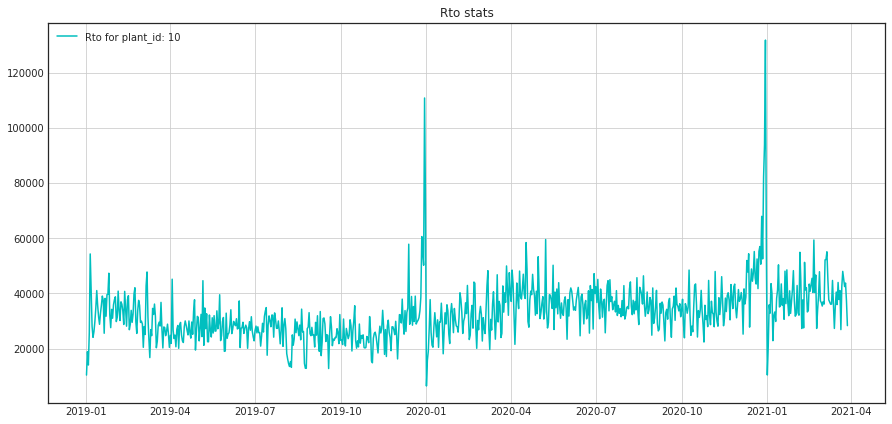

In [19]:
plotPlantRto(df, 10)

### Weekly granulation

Поскольку требуется оценить показатель за неделю, то сделаем понедельную агрегацию данных.

In [20]:
def make_week_frame(df, cols_to_keep, target_metrics, agg_func='sum'):
    """
    Создание фрейма с недельной гранулярностью. Среднее значение метрики
    с понедельника по воскресенье включительно сохраняется в дату воскресенья.
    """    
    assert agg_func in ['sum', 'mean']
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    week_df = (df
               .assign(period=pd.PeriodIndex(df['timestamp'], freq='W-Sun'))
               .groupby(['id', 'period'] + cols_to_keep)
               .agg({metric: agg_func for metric in target_metrics}).reset_index())
#     week_df['timestamp'] = \pd.to_datetime((week_df['year'] * 100 + week_df['week']).astype(str) + '0', 
#                                           format = '%Y%W%w')
    week_df['timestamp'] = week_df['period'].dt.to_timestamp(how='end')
    week_df['timestamp'] = week_df['timestamp'].dt.normalize()
#     week_df['week'] = week_df['timestamp'].dt.weekofyear

    return week_df

In [21]:
week_df = make_week_frame(df, ['region_nm'], ['rto', 'traffic'], 'sum')

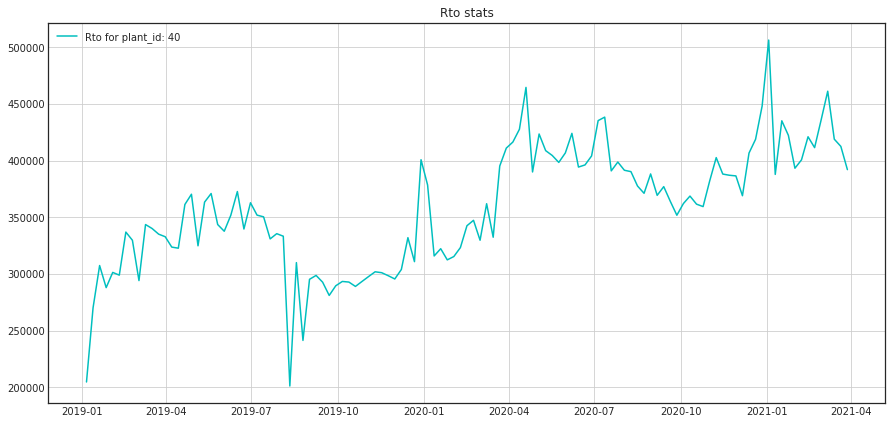

In [22]:
plotPlantRto(week_df, 40)

### Feature engineering

In [23]:
### year_before_rto, среднее по региону за текущую неделю, moving_average

На данном этапе формируются признаки, которые могут быть полезными для обучения моделей - значения показателя на прошлых неделях n_Weeks_before_rto и разница значения показателя на данной неделе и на предыдущей неделе n_Weeks_before_rto_diff. Признаков можно создать значительно больше, но для простоты бейзлайна оставим так. Также были созданы колонки со значениями показателя в будущем n_Weeks_after_rto, которые не будут использоваться в обучении, а созданы лишь для удобства формирования целевой переменной в обучающих и тестовых датасетах.

In [24]:
week_df = week_df.sort_values(['timestamp', 'id'])
for i in range(4):
    week_df[f'{i+1}_Weeks_before_rto'] = week_df.groupby(['id'])['rto'].shift(i+1)
    week_df[f'{i+1}_Weeks_before_rto_diff'] = week_df.groupby(['id'])['rto'].diff(i+1)
    
week_df = week_df.dropna().reset_index().drop(columns=['index'])
for i in range(4):
    week_df[f'{i+1}_Weeks_after_rto'] = week_df.groupby(['id'])['rto'].shift(-(i+1))

In [25]:
week_df['rto_last_year'] = week_df.groupby(['id'])['rto'].shift(53)
week_df['rto_last_year'].fillna(week_df.groupby(['id'])['rto_last_year'].shift(-53), inplace=True)

In [27]:
week_df.head()

,id,period,region_nm,rto,traffic,timestamp,1_Weeks_before_rto,1_Weeks_before_rto_diff,2_Weeks_before_rto,2_Weeks_before_rto_diff,3_Weeks_before_rto,3_Weeks_before_rto_diff,4_Weeks_before_rto,4_Weeks_before_rto_diff,1_Weeks_after_rto,2_Weeks_after_rto,3_Weeks_after_rto,4_Weeks_after_rto,rto_last_year
0,1,2019-01-28/2019-02-03,Аваллонэ,676487.97,3935.0,2019-02-03,707086.52,-30598.55,723778.15,-47290.18,686159.59,-9671.62,467010.11,209477.86,716537.17,721202.65,731562.44,688507.86,676487.97
1,2,2019-01-28/2019-02-03,Валимар,655126.39,3315.0,2019-02-03,640498.84,14627.55,650413.53,4712.86,629551.38,25575.01,470225.13,184901.26,652134.91,659287.26,649539.32,653664.83,655126.39
2,3,2019-01-28/2019-02-03,Ильмарин,593152.20,3504.0,2019-02-03,616039.53,-22887.33,595039.92,-1887.72,622805.31,-29653.11,378291.98,214860.22,587529.27,624342.20,582187.96,609155.17,593152.20
3,4,2019-01-28/2019-02-03,Тирион,787508.00,2748.0,2019-02-03,749036.10,38471.90,774117.33,13390.67,693229.32,94278.68,418346.13,369161.87,785754.78,749035.79,786116.47,744463.51,787508.00
4,5,2019-01-28/2019-02-03,Аваллонэ,661115.11,4016.0,2019-02-03,710342.92,-49227.81,670413.20,-9298.09,671656.26,-10541.15,445107.74,216007.37,735181.22,692661.99,704090.31,742689.93,661115.11


### Экспериментирование и валидация

В данном ноутбуке предложен подход, состоящий из комбинирования четырех моделей, где каждая модель отвечает за предсказание на различное число недель вперед. Модель под номером один предсказывает значение показателя на следующую неделю, модель под номером два - через одну неделю и так далее. 

Ниже определена функция для формирования данных для обучения и оценки ошибки, а также Кросс Валидация для временных рядов, особенностью которой является тот факт, что на каждом сплите мы обучаемся данных прошлого, а тестируемся на данных будущего относительно некоторого момента времени, что позволяет избежать подглядывание в бущущее при обучении и, как результат, получение смещенной оценки качества на валидации.

In [28]:
def make_train_target_split(df, model_num, train_idxs, test_idxs):
    df_new = df.copy()
    df_new['week_num'] = df_new['timestamp'].dt.isocalendar().week
    df_new['week_num'] = df_new['timestamp'].dt.isocalendar().week
    
    cols_to_drop = ([f'{i}_Weeks_after_rto' for i in range(1, 5) if i != model_num]
                     + ['timestamp', 'period', 'region_nm'])
#     print(model_num, cols_to_drop)
    
    df_new = df.drop(columns=cols_to_drop).rename(columns={f'{model_num}_Weeks_after_rto': 'target'})
    train_data, train_target, test_data, test_target = (df_new.drop(columns=['target']).iloc[train_idxs], 
                                                        df_new['target'].iloc[train_idxs],
                                                        df_new.drop(columns=['target']).iloc[test_idxs],
                                                        df_new['target'].iloc[test_idxs])
    return train_data[train_target.notna()], train_target[train_target.notna()], test_data, test_target

In [41]:
def TimeSeriesCV(df, model_func, metric_func, params, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=df['id'].nunique() * 4) 
    error_dict = {i: [] for i in range(1, 5)}
    for train, test in tqdm(tscv.split(df.dropna().values)):
        models_dict = {i: model_func(**params) for i in range(1, 5)}
        for i in range(1, 5):
            train_data, train_target, test_data, test_target = make_train_target_split(
                week_df, i, train, test)
            models_dict[i].fit(train_data, train_target)
            predictions = models_dict[i].predict(test_data)
            error_dict[i].append(metric_func(test_target, predictions))
    return error_dict

- Mean Absolute Percentage Error: метрика качества, используемая в данной работе, то же самое, что и MAE, но более удобная в интерпретации, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 


In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Бейзлайны

Протестируем несколько разных алгоритмов решения задачи регрессии. Значение метрики по 10 фолдам кросс-валидации усредняется для каждой из полученных моделей.

#### Ridge

In [44]:
params = {'normalize': True, 'alpha': 0.01, 'random_state': 0}
model_func = Ridge
cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
print(mean_cv_scores)

cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
print(mean_cv_scores_mae)

5it [00:03,  1.50it/s]


{1: 6.0299892772204995, 2: 6.935753606488417, 3: 7.6593069209972855, 4: 8.199686744494866}


5it [00:03,  1.57it/s]

{1: 49930.08967111609, 2: 58346.51864861265, 3: 65451.020516913406, 4: 70416.39223469453}


#### Linear Regression (no normalization) 

In [49]:
params = {'normalize': True}
model_func = LinearRegression
cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
print(mean_cv_scores)

cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
print(mean_cv_scores_mae)

Exception ignored in: <function tqdm.__del__ at 0x129723af0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.9/site-packages/tqdm/notebook.py", line 289, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
5it [00:04,  1.15it/s]


{1: 6.011077887930701, 2: 6.920949560762229, 3: 7.648408497434427, 4: 8.189234823161373}


5it [00:04,  1.16it/s]

{1: 49656.28112056869, 2: 58104.501331028914, 3: 65237.75689995388, 4: 70192.85869829223}


#### Random Forest

In [50]:
params = {'max_depth': 20, 'n_estimators': 100}
model_func = RandomForestRegressor
cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
print(mean_cv_scores)

cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
print(mean_cv_scores_mae)

5it [57:46, 693.37s/it]


{1: 6.209267168803651, 2: 7.050820552708645, 3: 7.946311196011406, 4: 8.605546374708613}


5it [5:01:34, 3618.90s/it]


{1: 51321.13680966224, 2: 59395.06420325709, 3: 67592.50610594642, 4: 72902.75973690778}


In [51]:
params = {'max_depth': 80, 'n_estimators': 100}
model_func = RandomForestRegressor
cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
print(mean_cv_scores)

cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
print(mean_cv_scores_mae)

5it [55:57, 671.55s/it]


{1: 6.281950125904723, 2: 7.133451510953985, 3: 8.067419944686451, 4: 8.71281697755646}


5it [51:32, 618.47s/it]


{1: 51913.466324525, 2: 60087.71952737833, 3: 68521.12256774, 4: 73615.52374819301}


#### XGB

In [52]:
params = {'booster': 'gbtree', 'max_depth': '20', 'n_estimators': 50}
model_func = XGBRegressor
cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
print(mean_cv_scores)

cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
print(mean_cv_scores_mae)

5it [4:51:11, 3494.34s/it]


{1: 6.816360381148063, 2: 7.7945694067379865, 3: 8.82706139810452, 4: 9.474741733164784}


5it [2:11:45, 1581.12s/it]

{1: 56313.01971440625, 2: 65780.7352564375, 3: 74589.21669728126, 4: 80244.064130875}


In [53]:
cv_results = {}
for a in tqdm([0, 0.1, 0.3, 0.5, 0.7, 1]):
    for l in [0, 0.1, 0.3, 0.5, 0.7, 1]:
        params = {'booster': 'gblinear', 'n_estimators': 100, 'alpha': a, 'lambda': l}
        model_func = XGBRegressor
        cv_scores = TimeSeriesCV(week_df, model_func, mean_absolute_percentage_error, params)
        mean_cv_scores = {k: np.mean(v) for k, v in cv_scores.items()}
        print(mean_cv_scores)

        cv_scores_mae = TimeSeriesCV(week_df, model_func, mean_absolute_error, params)
        mean_cv_scores_mae = {k: np.mean(v) for k, v in cv_scores_mae.items()}
        print(mean_cv_scores_mae)
        cv_results[f'{a}, {l}'] = [mean_cv_scores, mean_cv_scores_mae]

  0%|                                                     | 0/6 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:03,  4.00s/it]
2it [00:13,  7.08s/it]
3it [00:23,  8.67s/it]
4it [00:29,  7.33s/it]
5it [00:35,  7.16s/it]


{1: 6.015265638445157, 2: 6.9604171568043, 3: 7.685827472096188, 4: 8.25530795413934}



0it [00:00, ?it/s]
1it [00:04,  4.18s/it]
2it [00:07,  3.78s/it]
3it [00:11,  3.76s/it]
4it [00:14,  3.66s/it]
5it [00:18,  3.72s/it]


{1: 49582.87361321874, 2: 58040.03477478125, 3: 65135.40898553126, 4: 70107.62315671876}



0it [00:00, ?it/s]
1it [00:04,  4.30s/it]
2it [00:08,  4.38s/it]
3it [00:12,  4.30s/it]
4it [00:16,  4.05s/it]
5it [00:22,  4.43s/it]


{1: 6.0418333750269655, 2: 6.952792772656759, 3: 7.696338966432404, 4: 8.20641934409533}



0it [00:00, ?it/s]
1it [00:05,  5.24s/it]
2it [00:09,  4.79s/it]
3it [00:14,  4.75s/it]
4it [00:19,  4.80s/it]
5it [00:24,  4.84s/it]


{1: 49818.18265565626, 2: 58114.365285562504, 3: 65293.868533718734, 4: 70083.18134040626}



0it [00:00, ?it/s]
1it [00:04,  4.28s/it]
2it [00:08,  4.06s/it]
3it [00:11,  3.92s/it]
4it [00:16,  4.12s/it]
5it [00:21,  4.36s/it]


{1: 6.046574919258807, 2: 6.9498366548089034, 3: 7.675042503020362, 4: 8.221698485456626}



0it [00:00, ?it/s]
1it [00:04,  4.40s/it]
2it [00:09,  4.52s/it]
3it [00:13,  4.58s/it]
4it [00:18,  4.68s/it]
5it [00:25,  5.10s/it]


{1: 49796.583599375, 2: 58093.89539965625, 3: 65484.02502181249, 4: 69939.52222084375}



0it [00:00, ?it/s]
1it [00:05,  5.03s/it]
2it [00:11,  5.91s/it]
3it [00:22,  8.08s/it]
4it [00:47, 14.78s/it]
5it [00:57, 11.45s/it]


{1: 6.024963474728686, 2: 6.9516687931155925, 3: 7.7038832212734265, 4: 8.230089217676676}



0it [00:00, ?it/s]
1it [00:06,  6.41s/it]
2it [00:11,  5.42s/it]
3it [00:15,  5.15s/it]
4it [00:21,  5.36s/it]
5it [00:28,  5.67s/it]


{1: 49698.17888303124, 2: 58238.0662291875, 3: 65213.23963928125, 4: 70004.90174162501}



0it [00:00, ?it/s]
1it [00:04,  4.42s/it]
2it [00:08,  4.39s/it]
3it [00:13,  4.34s/it]
4it [00:17,  4.33s/it]
5it [00:21,  4.36s/it]


{1: 6.025125189688113, 2: 6.948282987309385, 3: 7.671199295075148, 4: 8.204195358095763}



0it [00:00, ?it/s]
1it [00:03,  3.39s/it]
2it [00:06,  3.47s/it]
3it [00:11,  3.89s/it]
4it [00:17,  4.89s/it]
5it [00:23,  4.64s/it]


{1: 49626.67363190625, 2: 58045.42641174999, 3: 65145.0408155, 4: 69837.79145475}



0it [00:00, ?it/s]
1it [00:04,  4.53s/it]
2it [00:09,  4.81s/it]
3it [00:14,  4.87s/it]
4it [00:19,  5.10s/it]
5it [00:25,  5.05s/it]


{1: 6.045495105171419, 2: 6.956021550708752, 3: 7.6552131943290025, 4: 8.197720754970769}



0it [00:00, ?it/s]
1it [00:04,  4.46s/it]
2it [00:09,  5.00s/it]
3it [00:15,  5.28s/it]
4it [00:20,  5.26s/it]
5it [00:25,  5.15s/it]
 17%|███████▎                                    | 1/6 [05:43<28:36, 343.38s/it]

{1: 49741.18943175, 2: 58073.5918398125, 3: 65320.947491875, 4: 69829.30368403126}



0it [00:00, ?it/s]
1it [00:05,  5.17s/it]
2it [00:09,  4.75s/it]
3it [00:13,  4.51s/it]
4it [00:18,  4.57s/it]
5it [00:23,  4.65s/it]


{1: 6.032387306409406, 2: 6.938667849311168, 3: 7.6840540893969305, 4: 8.21155701246209}



0it [00:00, ?it/s]
1it [00:03,  3.90s/it]
2it [00:08,  4.10s/it]
3it [00:12,  4.25s/it]
4it [00:16,  4.21s/it]
5it [00:21,  4.30s/it]


{1: 49646.479858499995, 2: 58054.99791865625, 3: 65446.9867776875, 4: 69917.7169614375}



0it [00:00, ?it/s]
1it [00:03,  3.75s/it]
2it [00:07,  3.97s/it]
3it [00:11,  3.97s/it]
4it [00:15,  4.02s/it]
5it [00:20,  4.08s/it]


{1: 6.039774382869437, 2: 6.948437068293647, 3: 7.67437438619987, 4: 8.217641181106575}



0it [00:00, ?it/s]
1it [00:04,  4.06s/it]
2it [00:11,  5.93s/it]
3it [00:16,  5.62s/it]
4it [00:22,  5.76s/it]
5it [00:27,  5.57s/it]


{1: 49972.3695385, 2: 58008.27314881251, 3: 65240.87362828125, 4: 69971.03079690626}



0it [00:00, ?it/s]
1it [00:04,  4.15s/it]
2it [00:10,  5.31s/it]
3it [00:16,  5.68s/it]
4it [00:22,  5.66s/it]
5it [00:27,  5.50s/it]


{1: 6.0409865441373745, 2: 6.945670329489296, 3: 7.675098895415113, 4: 8.173060539971166}



0it [00:00, ?it/s]
1it [00:04,  4.36s/it]
2it [00:08,  4.39s/it]
3it [00:12,  4.29s/it]
4it [00:17,  4.39s/it]
5it [00:22,  4.42s/it]


{1: 49822.4951754375, 2: 58085.89878853125, 3: 65219.45018546875, 4: 70095.25081459375}



0it [00:00, ?it/s]
1it [00:04,  4.13s/it]
2it [00:08,  4.18s/it]
3it [00:14,  4.92s/it]
4it [00:20,  5.45s/it]
5it [00:25,  5.13s/it]


{1: 6.040520930104213, 2: 6.959487285079467, 3: 7.672645263261056, 4: 8.210468595266871}



0it [00:00, ?it/s]
1it [00:04,  4.58s/it]
2it [00:09,  4.79s/it]
3it [00:14,  4.91s/it]
4it [00:19,  4.77s/it]
5it [00:24,  4.83s/it]


{1: 49638.88851431249, 2: 58105.948505312495, 3: 65191.390704906255, 4: 70044.1386245}



0it [00:00, ?it/s]
1it [00:04,  4.53s/it]
2it [00:08,  4.07s/it]
3it [00:12,  4.16s/it]
4it [00:18,  4.80s/it]
5it [00:23,  4.71s/it]


{1: 6.06149592900414, 2: 6.944816467867542, 3: 7.679584497782278, 4: 8.211979740758911}



0it [00:00, ?it/s]
1it [00:04,  4.13s/it]
2it [00:08,  4.09s/it]
3it [00:12,  4.23s/it]
4it [00:17,  4.43s/it]
5it [00:22,  4.46s/it]


{1: 49696.883749468754, 2: 58082.239397937505, 3: 65061.494033124996, 4: 69971.369826}



0it [00:00, ?it/s]
1it [00:04,  4.09s/it]
2it [00:08,  4.01s/it]
3it [00:12,  4.04s/it]
4it [00:18,  4.90s/it]
5it [00:22,  4.57s/it]


{1: 6.04050475879707, 2: 6.94869242510191, 3: 7.67873347781587, 4: 8.178513709059505}



0it [00:00, ?it/s]
1it [00:11, 11.45s/it]
2it [00:15,  7.10s/it]
3it [00:23,  7.49s/it]
4it [00:29,  7.10s/it]
5it [00:34,  6.98s/it]
 33%|██████████████▋                             | 2/6 [10:50<21:28, 322.24s/it]

{1: 49557.072560500004, 2: 58106.24160093749, 3: 65158.36667575, 4: 69996.8003660625}



0it [00:00, ?it/s]
1it [00:04,  4.51s/it]
2it [00:09,  5.00s/it]
3it [00:15,  5.35s/it]
4it [00:20,  5.13s/it]
5it [00:27,  5.42s/it]


{1: 6.0328185868296496, 2: 6.94428296756233, 3: 7.691247217143179, 4: 8.199300027787142}



0it [00:00, ?it/s]
1it [00:06,  6.75s/it]
2it [00:11,  5.55s/it]
3it [00:15,  5.03s/it]
4it [00:21,  5.42s/it]
5it [00:28,  5.65s/it]


{1: 49875.18923537501, 2: 58099.776959375, 3: 65273.21437803124, 4: 70059.62272346877}



0it [00:00, ?it/s]
1it [00:04,  4.09s/it]
2it [00:08,  4.16s/it]
3it [00:12,  4.16s/it]
4it [00:16,  4.17s/it]
5it [00:20,  4.19s/it]


{1: 6.034848095213437, 2: 6.947527359278038, 3: 7.677373024933601, 4: 8.205726675022706}



0it [00:00, ?it/s]
1it [00:03,  3.70s/it]
2it [00:07,  3.91s/it]
3it [00:12,  4.34s/it]
4it [00:17,  4.48s/it]
5it [00:22,  4.43s/it]


{1: 49701.56908934376, 2: 58172.223080250005, 3: 65020.26642040625, 4: 70020.59582971876}



0it [00:00, ?it/s]
1it [00:03,  3.90s/it]
2it [00:08,  4.07s/it]
3it [00:12,  4.16s/it]
4it [00:16,  4.24s/it]
5it [00:21,  4.28s/it]


{1: 6.047041018826174, 2: 6.946619724541715, 3: 7.67833570249252, 4: 8.219497322125058}



0it [00:00, ?it/s]
1it [00:03,  3.89s/it]
2it [00:07,  3.90s/it]
3it [00:12,  4.06s/it]
4it [00:16,  4.04s/it]
5it [00:19,  3.97s/it]


{1: 49660.09889750001, 2: 58097.32324037501, 3: 65179.42316940626, 4: 70079.9449815625}



0it [00:00, ?it/s]
1it [00:03,  3.51s/it]
2it [00:07,  3.84s/it]
3it [00:11,  3.80s/it]
4it [00:15,  3.82s/it]
5it [00:19,  3.90s/it]


{1: 5.996123928161922, 2: 6.945005857895216, 3: 7.660384463636115, 4: 8.212870852893365}



0it [00:00, ?it/s]
1it [00:03,  3.49s/it]
2it [00:07,  3.81s/it]
3it [00:14,  5.16s/it]
4it [00:21,  5.96s/it]
5it [00:26,  5.37s/it]


{1: 49562.280514531245, 2: 58144.89828803125, 3: 64978.27155821875, 4: 70287.74700340626}



0it [00:00, ?it/s]
1it [00:04,  4.21s/it]
2it [00:08,  4.50s/it]
3it [00:21,  8.31s/it]
4it [00:26,  7.01s/it]
5it [00:31,  6.37s/it]


{1: 6.097764999185841, 2: 6.9362637883889775, 3: 7.660866211334893, 4: 8.211676265469794}



0it [00:00, ?it/s]
1it [00:05,  5.16s/it]
2it [00:09,  4.79s/it]
3it [00:14,  4.78s/it]
4it [00:19,  5.00s/it]
5it [00:25,  5.10s/it]


{1: 49669.53638184375, 2: 58116.464616437486, 3: 65318.22154453125, 4: 70025.05479790624}



0it [00:00, ?it/s]
1it [00:04,  4.52s/it]
2it [00:13,  7.24s/it]
3it [00:21,  7.36s/it]
4it [00:25,  6.19s/it]
5it [00:31,  6.35s/it]


{1: 6.023563447634673, 2: 6.94971640034103, 3: 7.672671978094913, 4: 8.262845327648927}



0it [00:00, ?it/s]
1it [00:03,  3.97s/it]
2it [00:07,  3.85s/it]
3it [00:13,  4.58s/it]
4it [00:18,  5.03s/it]
5it [00:24,  4.88s/it]
 50%|██████████████████████                      | 3/6 [16:02<15:52, 317.41s/it]

{1: 49585.955922124995, 2: 58172.67269071875, 3: 65344.19404978125, 4: 70209.126696625}



0it [00:00, ?it/s]
1it [00:03,  3.82s/it]
2it [00:08,  4.30s/it]
3it [00:12,  4.13s/it]
4it [00:16,  4.13s/it]
5it [00:20,  4.07s/it]


{1: 6.02871681272289, 2: 6.952698378956891, 3: 7.6672219418012215, 4: 8.176799046851974}



0it [00:00, ?it/s]
1it [00:03,  3.44s/it]
2it [00:07,  3.51s/it]
3it [00:11,  3.76s/it]
4it [00:15,  3.92s/it]
5it [00:19,  3.82s/it]


{1: 49631.779590687496, 2: 58080.16265499999, 3: 65253.211808406246, 4: 70125.88640525}



0it [00:00, ?it/s]
1it [00:03,  3.07s/it]
2it [00:06,  3.17s/it]
3it [00:09,  3.32s/it]
4it [00:13,  3.58s/it]
5it [00:17,  3.49s/it]


{1: 6.036751309029335, 2: 6.941685698197463, 3: 7.678115217543072, 4: 8.23730442047674}



0it [00:00, ?it/s]
1it [00:03,  3.21s/it]
2it [00:06,  3.29s/it]
3it [00:10,  3.45s/it]
4it [00:13,  3.52s/it]
5it [00:17,  3.50s/it]


{1: 49757.75091168749, 2: 58103.918314531256, 3: 65168.05183224999, 4: 69829.5622724375}



0it [00:00, ?it/s]
1it [00:03,  3.43s/it]
2it [00:06,  3.49s/it]
3it [00:11,  3.75s/it]
4it [00:14,  3.70s/it]
5it [00:18,  3.72s/it]


{1: 6.035066839895157, 2: 6.9437648097969955, 3: 7.679933742453781, 4: 8.219134086813108}



0it [00:00, ?it/s]
1it [00:02,  2.99s/it]
2it [00:06,  3.33s/it]
3it [00:09,  3.31s/it]
4it [00:13,  3.56s/it]
5it [00:17,  3.51s/it]


{1: 49695.210131125, 2: 58078.498424625, 3: 65222.6697990625, 4: 70109.89776015625}



0it [00:00, ?it/s]
1it [00:03,  3.37s/it]
2it [00:07,  3.95s/it]
3it [00:11,  3.78s/it]
4it [00:14,  3.74s/it]
5it [00:18,  3.74s/it]


{1: 6.0230478580070805, 2: 6.953401734807164, 3: 7.667679509750466, 4: 8.172731183711466}



0it [00:00, ?it/s]
1it [00:03,  3.00s/it]
2it [00:06,  3.35s/it]
3it [00:09,  3.35s/it]
4it [00:13,  3.52s/it]
5it [00:17,  3.54s/it]


{1: 49640.621356375006, 2: 58085.12203225, 3: 65146.56352968749, 4: 69957.80735503125}



0it [00:00, ?it/s]
1it [00:03,  3.34s/it]
2it [00:07,  3.64s/it]
3it [00:11,  3.73s/it]
4it [00:15,  3.87s/it]
5it [00:19,  3.85s/it]


{1: 6.029661895328028, 2: 6.951636849963576, 3: 7.673498818664408, 4: 8.196131935430351}



0it [00:00, ?it/s]
1it [00:03,  3.46s/it]
2it [00:07,  3.59s/it]
3it [00:11,  4.05s/it]
4it [00:16,  4.50s/it]
5it [00:21,  4.36s/it]


{1: 49670.27301684375, 2: 58096.89505471875, 3: 65290.809992906245, 4: 69888.9389978125}



0it [00:00, ?it/s]
1it [00:03,  3.04s/it]
2it [00:06,  3.22s/it]
3it [00:09,  3.35s/it]
4it [00:13,  3.53s/it]
5it [00:17,  3.56s/it]


{1: 6.087441028729822, 2: 6.941808320004332, 3: 7.6684940430314175, 4: 8.202088001965816}



0it [00:00, ?it/s]
1it [00:03,  3.32s/it]
2it [00:06,  3.40s/it]
3it [00:10,  3.55s/it]
4it [00:14,  3.54s/it]
5it [00:17,  3.59s/it]
 67%|█████████████████████████████▎              | 4/6 [19:56<09:28, 284.48s/it]

{1: 49825.12415084375, 2: 58060.78840009375, 3: 65101.150102562504, 4: 70081.786753375}



0it [00:00, ?it/s]
1it [00:03,  3.38s/it]
2it [00:06,  3.50s/it]
3it [00:10,  3.69s/it]
4it [00:14,  3.66s/it]
5it [00:18,  3.65s/it]


{1: 6.032174448620041, 2: 6.948235842706097, 3: 7.682935409359118, 4: 8.18833911846075}



0it [00:00, ?it/s]
1it [00:03,  3.59s/it]
2it [00:07,  3.73s/it]
3it [00:10,  3.56s/it]
4it [00:14,  3.55s/it]
5it [00:18,  3.61s/it]


{1: 49651.855759750004, 2: 58101.025500218755, 3: 65208.87717009375, 4: 70095.2327969375}



0it [00:00, ?it/s]
1it [00:03,  3.28s/it]
2it [00:06,  3.35s/it]
3it [00:10,  3.45s/it]
4it [00:13,  3.50s/it]
5it [00:17,  3.58s/it]


{1: 6.022439011979154, 2: 6.946995057711777, 3: 7.666962136818974, 4: 8.198189139695277}



0it [00:00, ?it/s]
1it [00:03,  3.11s/it]
2it [00:06,  3.34s/it]
3it [00:10,  3.57s/it]
4it [00:14,  3.68s/it]
5it [00:18,  3.68s/it]


{1: 49690.08360771874, 2: 58093.13867815625, 3: 65274.51979675, 4: 70016.24346187501}



0it [00:00, ?it/s]
1it [00:03,  3.14s/it]
2it [00:06,  3.22s/it]
3it [00:10,  3.57s/it]
4it [00:13,  3.53s/it]
5it [00:17,  3.52s/it]


{1: 6.037114367157311, 2: 6.946404212838476, 3: 7.667256918375337, 4: 8.171708393024103}



0it [00:00, ?it/s]
1it [00:03,  3.20s/it]
2it [00:06,  3.29s/it]
3it [00:10,  3.39s/it]
4it [00:13,  3.49s/it]
5it [00:17,  3.51s/it]


{1: 49689.46029371875, 2: 58071.18151590625, 3: 65257.77654749999, 4: 70015.71111296875}



0it [00:00, ?it/s]
1it [00:03,  3.11s/it]
2it [00:06,  3.28s/it]
3it [00:11,  4.24s/it]
4it [00:15,  3.97s/it]
5it [00:19,  3.82s/it]


{1: 6.0326912848781955, 2: 6.952293034271764, 3: 7.663848149959618, 4: 8.257166589984331}



0it [00:00, ?it/s]
1it [00:03,  3.08s/it]
2it [00:06,  3.12s/it]
3it [00:09,  3.22s/it]
4it [00:13,  3.33s/it]
5it [00:16,  3.34s/it]


{1: 49644.686259625, 2: 58061.351522031255, 3: 65142.949915625, 4: 70094.094542875}



0it [00:00, ?it/s]
1it [00:03,  3.20s/it]
2it [00:07,  3.59s/it]
3it [00:10,  3.57s/it]
4it [00:16,  4.62s/it]
5it [00:21,  4.33s/it]


{1: 6.058345601686417, 2: 6.94910085532716, 3: 7.67786398020084, 4: 8.215331717546874}



0it [00:00, ?it/s]
1it [00:04,  4.75s/it]
2it [00:08,  4.29s/it]
3it [00:14,  4.76s/it]
4it [00:18,  4.51s/it]
5it [00:21,  4.37s/it]


{1: 49587.0969331875, 2: 58009.902324124996, 3: 65157.17205875, 4: 69988.8928623125}



0it [00:00, ?it/s]
1it [00:03,  3.05s/it]
2it [00:06,  3.34s/it]
3it [00:10,  3.38s/it]
4it [00:13,  3.43s/it]
5it [00:17,  3.44s/it]


{1: 6.028811363859768, 2: 6.95198793712072, 3: 7.6682765607725045, 4: 8.201830483457957}



0it [00:00, ?it/s]
1it [00:03,  3.06s/it]
2it [00:06,  3.18s/it]
3it [00:09,  3.33s/it]
4it [00:13,  3.35s/it]
5it [00:18,  3.79s/it]
 83%|████████████████████████████████████▋       | 5/6 [23:49<04:25, 265.89s/it]

{1: 49649.229418468756, 2: 58149.49999900001, 3: 65207.789738562504, 4: 69782.52567934376}



0it [00:00, ?it/s]
1it [00:03,  3.09s/it]
2it [00:06,  3.20s/it]
3it [00:09,  3.32s/it]
4it [00:13,  3.35s/it]
5it [00:18,  3.67s/it]


{1: 6.029507371062164, 2: 6.937710337336455, 3: 7.671669759988707, 4: 8.159919529583359}



0it [00:00, ?it/s]
1it [00:03,  3.63s/it]
2it [00:07,  3.57s/it]
3it [00:10,  3.51s/it]
4it [00:14,  3.67s/it]
5it [00:19,  3.86s/it]


{1: 49781.09291009375, 2: 58034.77966293751, 3: 65259.77142525, 4: 70055.322164625}



0it [00:00, ?it/s]
1it [00:03,  3.00s/it]
2it [00:06,  3.15s/it]
3it [00:09,  3.25s/it]
4it [00:13,  3.30s/it]
5it [00:16,  3.38s/it]


{1: 6.032976935105751, 2: 6.935750781578113, 3: 7.673253871405441, 4: 8.216296131852864}



0it [00:00, ?it/s]
1it [00:03,  3.10s/it]
2it [00:06,  3.14s/it]
3it [00:09,  3.18s/it]
4it [00:12,  3.27s/it]
5it [00:16,  3.31s/it]


{1: 49515.37866753125, 2: 58122.57324378125, 3: 65187.222397781254, 4: 70044.04976640624}



0it [00:00, ?it/s]
1it [00:03,  3.10s/it]
2it [00:06,  3.29s/it]
3it [00:09,  3.33s/it]
4it [00:13,  3.47s/it]
5it [00:17,  3.46s/it]


{1: 6.0367695292689785, 2: 6.952611332986246, 3: 7.67402957806799, 4: 8.203063920436916}



0it [00:00, ?it/s]
1it [00:02,  2.99s/it]
2it [00:06,  3.12s/it]
3it [00:09,  3.26s/it]
4it [00:13,  3.32s/it]
5it [00:16,  3.32s/it]


{1: 49648.431456718754, 2: 58087.01831859376, 3: 65171.98064368749, 4: 69915.101782875}



0it [00:00, ?it/s]
1it [00:02,  2.97s/it]
2it [00:06,  3.58s/it]
3it [00:10,  3.49s/it]
4it [00:13,  3.51s/it]
5it [00:18,  3.69s/it]


{1: 6.028963277278011, 2: 6.957450439963641, 3: 7.671366293421419, 4: 8.193517030716372}



0it [00:00, ?it/s]
1it [00:03,  3.03s/it]
2it [00:06,  3.12s/it]
3it [00:09,  3.23s/it]
4it [00:14,  3.78s/it]
5it [00:20,  4.08s/it]


{1: 49803.220911000004, 2: 58090.20327509375, 3: 65214.648753968744, 4: 69970.23606565625}



0it [00:00, ?it/s]
1it [00:05,  5.04s/it]
2it [00:10,  5.32s/it]
3it [00:15,  5.16s/it]
4it [00:19,  4.67s/it]
5it [00:23,  4.72s/it]


{1: 6.03372045150729, 2: 6.950979867469842, 3: 7.698829894180124, 4: 8.221545404222317}



0it [00:00, ?it/s]
1it [00:03,  3.72s/it]
2it [00:08,  4.30s/it]
3it [00:14,  5.14s/it]
4it [00:19,  5.24s/it]
5it [00:24,  4.94s/it]


{1: 49881.71453581249, 2: 58030.649975875, 3: 65346.89214515626, 4: 70042.57895462502}



0it [00:00, ?it/s]
1it [00:03,  3.90s/it]
2it [00:09,  4.89s/it]
3it [00:13,  4.67s/it]
4it [00:19,  4.95s/it]
5it [00:23,  4.73s/it]


{1: 6.036796559958562, 2: 6.9576959430855165, 3: 7.673994532779443, 4: 8.226010237629845}



0it [00:00, ?it/s]
1it [00:03,  3.99s/it]
2it [00:10,  5.36s/it]
3it [00:15,  5.32s/it]
4it [00:21,  5.42s/it]
5it [00:27,  5.59s/it]
100%|████████████████████████████████████████████| 6/6 [28:04<00:00, 280.67s/it]

{1: 49894.57442209375, 2: 58110.64324525, 3: 64999.94126284375, 4: 69765.178001125}


In [54]:
from copy import deepcopy
cv_results_2 = deepcopy(cv_results)

In [55]:
for k, v in cv_results_2.items():
    cv_results_2[k] = np.mean(list(v[1].values()))

In [56]:
for k, v in cv_results_2.items():
    if v == min(cv_results_2.values()):
        print(k, v)

0, 0.7 60663.73307847656


### Формирование предсказания

Поскольку, в нашем датафрейме последняя неделя заканчивается 28 марта 2021 года, то предсказания по последним 1000 записям фрейма на 1, 2, 3, 4 недели будет являться искомым результатом.

In [57]:
def make_prediction(df, model_func, params):
    models_dict = {i: model_func(**params) for i in range(1, 5)}
    result_df = pd.DataFrame(df['id'].unique()).rename(columns={0:'id'})
    for i in range(1, 5):
        train_data, train_target, test_data, _ = make_train_target_split(week_df, 
                                                                 i, 
                                                                 np.arange(0, df.shape[0])[:-1000], 
                                                                 np.arange(0, df.shape[0])[-1000:])
        models_dict[i].fit(train_data, train_target)
        result_df[f'week_{i}'] = models_dict[i].predict(test_data)
    return result_df

In [58]:
XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [59]:
params = {'booster': 'gblinear', 'n_estimators': 500, 'alpha': 0.5, 'lambda': 0.7}
model_func = XGBRegressor
result_df = make_prediction(week_df, model_func, params)

In [60]:
result_df.shape

(1000, 5)

In [61]:
result_df.head()

,id,week_1,week_2,week_3,week_4
0,1,1.016993e+06,1.008662e+06,1.006944e+06,1.003199e+06
1,2,7.353964e+05,7.373493e+05,7.355768e+05,7.368410e+05
2,3,7.790504e+05,7.804375e+05,7.806039e+05,7.798508e+05
3,4,1.071227e+06,1.081056e+06,1.079424e+06,1.086636e+06
4,5,8.131624e+05,8.073095e+05,8.095142e+05,8.079418e+05


In [ ]:
week_sum_in_regions = week_df.groupby(['region_nm', 'period']).sum() \
                      .reset_index().iloc[:, :4].drop(['id'], axis=1) \
                      .rename({'rto': 'weekly_reg_sum'}, axis=1)

week_sum_in_regions['rolling_month_mean_reg'] = week_sum_in_regions.weekly_reg_sum.shift(1).rolling(4).mean()
week_sum_in_regions.loc[week_sum_in_regions.period.isin \
                    (week_sum_in_regions.period.unique()[:4]),
                       'rolling_month_mean_reg'] = np.nan

week_df = week_df.merge(week_sum_in_regions, how='left',
                        on=['region_nm', 'period'])

In [62]:
result_df.to_csv('xgb_year_feature.csv', index=False)

### Гипотеза: Разбить датасет по регионам

In [63]:
week_df.head(2)

,id,period,region_nm,rto,traffic,timestamp,1_Weeks_before_rto,1_Weeks_before_rto_diff,2_Weeks_before_rto,2_Weeks_before_rto_diff,3_Weeks_before_rto,3_Weeks_before_rto_diff,4_Weeks_before_rto,4_Weeks_before_rto_diff,1_Weeks_after_rto,2_Weeks_after_rto,3_Weeks_after_rto,4_Weeks_after_rto,rto_last_year
0,1,2019-01-28/2019-02-03,Аваллонэ,676487.97,3935.0,2019-02-03,707086.52,-30598.55,723778.15,-47290.18,686159.59,-9671.62,467010.11,209477.86,716537.17,721202.65,731562.44,688507.86,676487.97
1,2,2019-01-28/2019-02-03,Валимар,655126.39,3315.0,2019-02-03,640498.84,14627.55,650413.53,4712.86,629551.38,25575.01,470225.13,184901.26,652134.91,659287.26,649539.32,653664.83,655126.39


In [64]:
regions = week_df.region_nm.unique()

In [65]:
region_dfs = []
for region in regions:
    region_dfs.append(week_df[week_df.region_nm == region])

In [66]:
for _df in region_dfs:
    _df = _df.reset_index(drop=True)

In [67]:
# params = {'normalize': True}
# model_func = LinearRegression
# for _df in tqdm(region_dfs):
#     result_df = make_prediction(_df, model_func, params)

In [69]:
def make_train_target_split(df, model_num, train_idxs, test_idxs):
    df_new = df.copy()
    df_new['week_num'] = df_new['timestamp'].dt.isocalendar().week
    df_new['week_num'] = df_new['timestamp'].dt.isocalendar().week
    
    cols_to_drop = ([f'{i}_Weeks_after_rto' for i in range(1, 5) if i != model_num]
                     + ['timestamp', 'period', 'region_nm'])
#     print(model_num, cols_to_drop)
    
    df_new = df.drop(columns=cols_to_drop).rename(columns={f'{model_num}_Weeks_after_rto': 'target'})
    train_data, train_target, test_data, test_target = (df_new.drop(columns=['target']).iloc[train_idxs], 
                                                        df_new['target'].iloc[train_idxs],
                                                        df_new.drop(columns=['target']).iloc[test_idxs],
                                                        df_new['target'].iloc[test_idxs])
    return train_data[train_target.notna()], train_target[train_target.notna()], test_data, test_target


def make_prediction(df, model_func, params):
    models_dict = {i: model_func(**params) for i in range(1, 5)}
    result_df = pd.DataFrame(week_df['id'].unique()).rename(columns={0:'id'})
    for i in range(1, 5):
        train_data, train_target, test_data, _ = make_train_target_split(week_df, 
                                                                 i, 
                                                                 np.arange(0, df.shape[0])[:-round(df.shape[0]*0.2)], 
                                                                 np.arange(0, df.shape[0])[-round(df.shape[0]*0.2):])
        models_dict[i].fit(train_data, train_target)
        result_df[f'week_{i}'] = models_dict[i].predict(test_data)
    return result_df

In [70]:
params = {'normalize': True}
model_func = LinearRegression
result_df = make_prediction(week_df, model_func, params)

ValueError: Length of values (22600) does not match length of index (1000)

In [94]:
# df_new = _df.copy()
# df_new['week_num'] = df_new['timestamp'].dt.isocalendar().week
# cols_to_drop = ([f'{i}_Weeks_after_rto' for i in range(1, 5) if i != 2]
#                      + ['timestamp', 'period', 'region_nm'])
# # df_new = _df.drop(columns=cols_to_drop).rename(columns={f'{2}_Weeks_after_rto': 'target'})
# # df_new

In [2]:
week_df.iloc[np.arange(0, week_df.shape[0])[-1001:]]

NameError: name 'week_df' is not defined